In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from xgboost import XGBRegressor


In [ ]:
df = pd.read_csv('./data/insurance.csv')
X = df.drop('charges', axis=1)
y = df['charges']

categorical_cols = ['sex', 'smoker', 'region']

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), categorical_cols)
], remainder='passthrough')


In [ ]:
# Definir pipeline com XGBoost (sem treinar ainda)
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('regressor', XGBRegressor(objective='reg:squarederror', random_state=42))
])

# Definir grid de hiperparâmetros
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [3, 4, 5],
    'regressor__learning_rate': [0.05, 0.1, 0.2]
}


In [ ]:
# Aplicar Grid Search com validação cruzada
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_search.fit(X, y)

# Melhores parâmetros encontrados
print("Melhores parâmetros encontrados:")
print(grid_search.best_params_)

# Melhor modelo
best_model = grid_search.best_estimator_


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Melhores parâmetros encontrados:
{'regressor__learning_rate': 0.05, 'regressor__max_depth': 3, 'regressor__n_estimators': 100}


In [ ]:
# Dividir dados para teste final
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinar modelo com melhores parâmetros nos dados de treino
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Avaliar
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mean_charges = y.mean()

print(f"R²: {r2:.3f}")
print(f"RMSE: {rmse:.2f} ({rmse/mean_charges*100:.1f}% da média)")
print(f"MAE: {mae:.2f} ({mae/mean_charges*100:.1f}% da média)")


R²: 0.884
RMSE: 4236.27 (31.9% da média)
MAE: 2452.99 (18.5% da média)


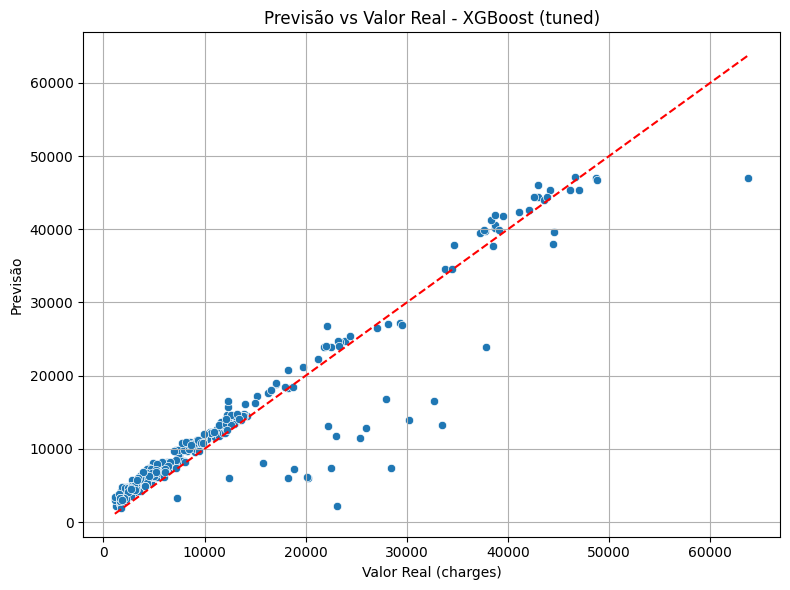

In [ ]:
# Gráfico: Previsão vs Valor Real
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel('Valor Real (charges)')
plt.ylabel('Previsão')
plt.title('Previsão vs Valor Real - XGBoost (tuned)')
plt.grid(True)
plt.tight_layout()
plt.show()


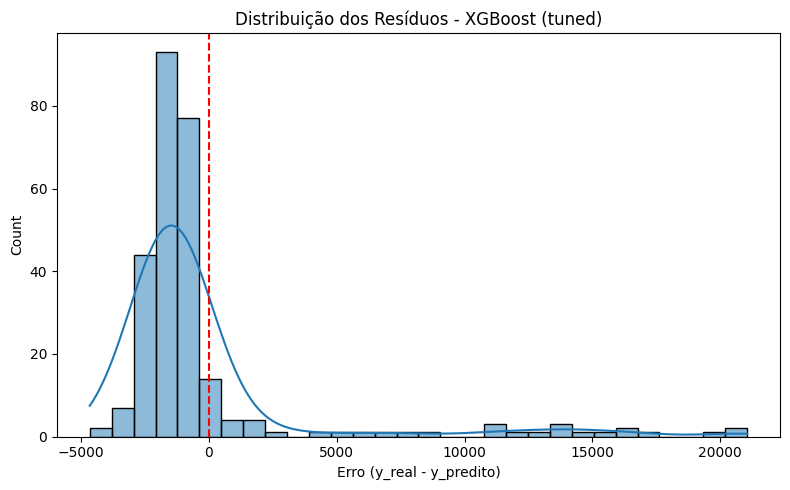

In [ ]:
# Gráfico de Resíduos
residuos = y_test - y_pred
plt.figure(figsize=(8, 5))
sns.histplot(residuos, bins=30, kde=True)
plt.title('Distribuição dos Resíduos - XGBoost (tuned)')
plt.xlabel('Erro (y_real - y_predito)')
plt.axvline(0, color='red', linestyle='--')
plt.tight_layout()
plt.show()
